In [5]:
from IPython.display import HTML
tog='''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''';

def init_esplot():
    plt.close('all');
    fig=plt.figure(figsize=[10, 4]);
    ax=plt.subplot(1,1,1)
    return(ax,fig)
HTML(tog)


In [6]:
%matplotlib inline
execfile('rep_util.py')
execfile('ccycle_util.py')

0.37652461702


14
88
88


/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


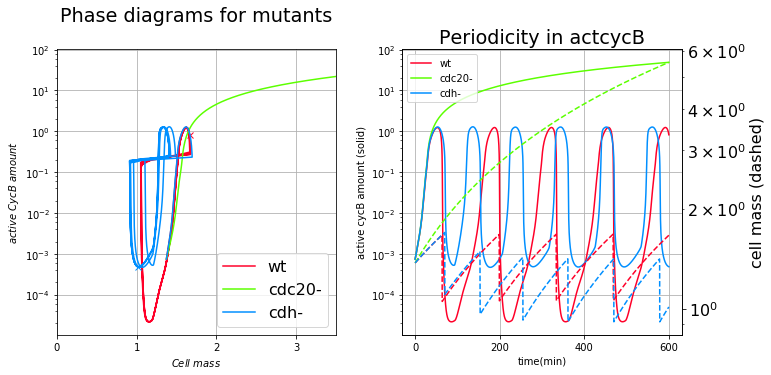

In [7]:
###figure1
# %matplotlib notebook
figname='resources/ccycle.jpg';

tl='''Phase diagrams for mutants
'''
# $k_{mRNA degrade} = 10^{log\_par}$

tlR='''Amplitude and Period bifurcation
'''

exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
axL=fig1.add_subplot(1,2,1)
ax3=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})
axL.set_title(tl);
axR.set_title(tlR);
ax32 = ax3.twinx()
# cm=plt.get_cmap('gist_rainbow')


#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
# lst=np.linspace(-6.,0,2);
lst=[];lbllst=[];
lbllst.append('wt')
lst.append('');
lbllst.append('cdc20-')
lst.append('''
MDT=1E2;
ks20p=0E2;
ks20pp=0E2;
''')

lbllst.append('cdh-')
lst.append('''
kah1p=0E2;
kah1pp=0E2;
''')


# lst.append('''
# cstval[cstdict['cdh1T']]=.1E5;
# cstval[cstdict['cdh1T']]=1.E0;
# cstval[cstdict['MDT']]=70.;''')
siz=len(lst)


cmd_onthefly_param='''
#### Temporary parameter/variable change
#k_dm = 10**log_par;    
#s = np.random.random(len(varname))
s=steady_ccycle;
param=cstval[:len(param)]
exec(cmd_unpack_all)
exec(lst[i])
log_par=i;
'''

#### timescales
t_max=10.*60.#### set the duration of the simulation
# unit=.05; ##### 1 for 1s, 60 for 1min etc
nt=1/.25; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
dt=1./nt;
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(20000*nt); 

exec(cmd_default_setup)
init_params('Scere')
param=cstval;
exec(cmd_name2dict)
exec(cmd_precompile_cmd)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
#dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
# dot_det = sdot
cmd_calcrates=precompile(sdot_ccycle);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)



for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
#     lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    lbl=lbllst[i];
    xs=mass_obs ;ys=actcycB_obs;
    
    period,amplitude,avg=analyse(ys,debug=0,threshold=20) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
#     ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    axL.plot(xs,ys,color=col,label=lbl)
    axL.plot(xs[-1],ys[-1],'x',color=col)
#     axR.plot(log_par,period/60.,'bx',label=lbl);
#     axR2.plot(log_par,amplitude,'ro',label=lbl);
    ax3.plot(t_obs,ys,color=col,label=lbl);
    ax32.plot(t_obs,xs,'--',color=col,label=lbl);
    
    

axL.set_xlim(0,3.5)
# axL.set_ylim(1E-1,6000)
# axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('${Cell\ mass}$')
axL.set_ylabel('${active\ CycB\ amount}$')

# cm=plt.get_cmap('gist_rainbow')
# Z = [[0,0],[0,0]]
# levels = [0,1];
# CS3 = axR.contourf(Z, levels, cmap=cm)
# cbar=plt.colorbar(CS3,ax=axL)
# cbar.set_label('$log\_par$', rotation=270)
# plt.colorbar( [0,1],ax=axL)
# norm = mpl.colors.Normalize(vmin=-2, vmax=3)
# cb = mpl.colorbar.ColorbarBase(axL, cmap=cm, norm=norm, spacing='proportional')
# plt.show(fig1)

# plt.colorbar(ax=axL)
axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
# axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')
axR.set_ylim(0,300)

ax3.set_xlabel('time(min)');
ax3.set_ylabel('active cycB amount (solid)');
ax32.set_ylabel('cell mass (dashed)')
ax32.set_yscale('log')
ax3.set_yscale('log')
ax3.set_title('Periodicity in actcycB')
ax3.legend(loc=2,prop={'size':10})

axL.grid(True)
axR.grid(True)
ax3.grid(True)
plt.tight_layout()
plt.savefig(figname,dpi=300)


/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


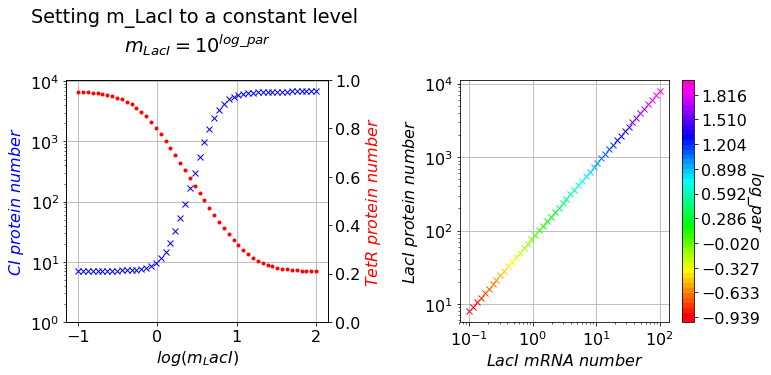

In [8]:
### figure3
# %matplotlib notebook

tl='''Setting m_LacI to a constant level 
$m_{LacI} = 10^{log\_par}$
'''

# exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
axL=fig1.add_subplot(1,2,1)
axL2=axL.twinx();
axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})
cm=plt.get_cmap('gist_rainbow')


axL.set_title(tl);
#### timescales
t_max=1000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(10000*nt); 

exec(cmd_default_setup)
parname = 'm_LacI'
varname.pop(vardict[parname])
cstname.append(parname)
exec(cmd_name2dict)
exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)


#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(-1.,2.,50);
siz=len(lst)

cmd_onthefly_param='''
#### Temporary parameter/variable change
m_LacI = 10**(log_par)
    
'''

for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)


    x=max(int(period*nt),5);
#     ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    axL.plot(log_par,p_CI_obs[-1],'bx',label=lbl)
    axL.plot(log_par,p_TetR_obs[-1],'r.',label=lbl)
    
#     axL.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
#     axL.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    axR.plot(m_LacI,p_LacI_obs[-1],'x',color=col,label=lbl)
#     axR.plot(p_CI_obs[-1],p_TetR_obs[-1],'x',color=col)



# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000)
# axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('$log(m_LacI)$')
axL.set_ylabel('$CI\ protein\ number$',color='b')
axL2.set_ylabel('$TetR\ protein\  number$',color='r')

axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlabel('$LacI\ mRNA\  number$')
axR.set_ylabel('$LacI\ protein\ number$')


cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axL.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axR)
cbar.set_label('$log\_par$', rotation=270)
# plt.colorbar( [0,1],ax=axL)
# norm = mpl.colors.Normalize(vmin=-2, vmax=3)
# cb = mpl.colorbar.ColorbarBase(axL, cmap=cm, norm=norm, spacing='proportional')
# plt.show(fig1)

# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()

axL.grid(True)
axR.grid(True)

plt.tight_layout()
plt.savefig('resources/m_LacI_cst.jpg',dpi=300)

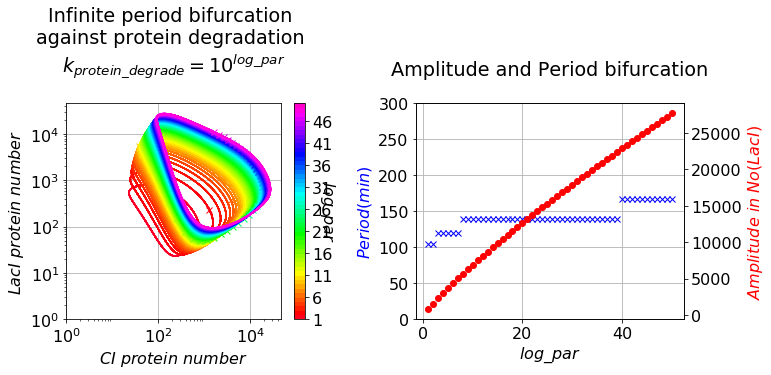

In [9]:
###figure4

# %matplotlib notebook

tl='''Infinite period bifurcation 
against protein degradation 
$k_{protein\_degrade} = 10^{log\_par}$
'''
tlR='''Amplitude and Period bifurcation
'''

# exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=1000.*60.#### set the duration of the simulation
nt=10; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(50000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)


#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(1,50,50);
siz=len(lst)

cmd_onthefly_param='''
#### Temporary parameter/variable change
cpnum = log_par;
    
'''

for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=20) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
#     ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    axL.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axL.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('$CI\ protein\ number$')
axL.set_ylabel('$LacI\ protein\  number$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axL.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
cbar.set_label('$log\_par$', rotation=270)
# plt.colorbar( [0,1],ax=axL)
# norm = mpl.colors.Normalize(vmin=-2, vmax=3)
# cb = mpl.colorbar.ColorbarBase(axL, cmap=cm, norm=norm, spacing='proportional')
# plt.show(fig1)

# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')
axR.set_ylim(0,300)

axL.grid(True)
axR.grid(True)

plt.tight_layout()
plt.savefig('resources/cpnum_0-50.jpg',dpi=300)

/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


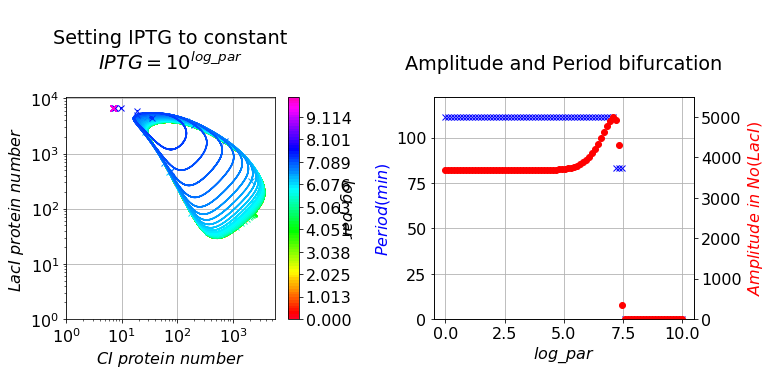

In [10]:
### figure5
# %matplotlib notebook

tl='''
Setting IPTG to constant
$IPTG = 10^{log\_par}$
'''
tlR='''Amplitude and Period bifurcation
'''
figname = 'resources/IPTG_varB.jpg';
# exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
# fig1=plt.figure(figsize=[5.5,5.5])

# cbaxes = fig1.add_axes([0.0, 0.1, 0.012, 0.8])
axL=fig1.add_subplot(1,2,1)
# axL=fig1.add_axes([0.15, 0.1, 0.4, 0.8])
axR=fig1.add_subplot(1,2,2)
cm=plt.get_cmap('gist_rainbow')
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=1000.*60.#### set the duration of the simulation
nt=2; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(20000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)


#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(0.,10,80);
siz=len(lst)
#####


cmd_onthefly_param='''
#### Temporary parameter/variable change
IPTG=10**(log_par)
    
'''
perlst=[];
amplst=[];
for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
#     ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    axL.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axL.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    perlst.append(period/60)
    amplst.append(amplitude)
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('$CI\ protein\ number$')
axL.set_ylabel('$LacI\ protein\  number$')

Z = [[0,0],[0,0]]
levels = lst;
CS3 = axL.contourf(Z, levels, cmap=cm)

# cbaxes = fig1.add_axes([0.1, 0.1, 0.03, 0.8])
cbar=plt.colorbar(CS3,ax=axL)
cbar.set_label('$log\_par$', rotation=270)
# plt.colorbar( [0,1],ax=axL)
# norm = mpl.colors.Normalize(vmin=-2, vmax=3)
# cb = mpl.colorbar.ColorbarBase(axL, cmap=cm, norm=norm, spacing='proportional')
# plt.show(fig1)

# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
axR.set_ylim(0,max(perlst)*1.1)
axR2.set_ylim(0,max(amplst)*1.1)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')


axL.grid(True)
axR.grid(True)

plt.tight_layout()
plt.savefig(figname,dpi=300)

/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


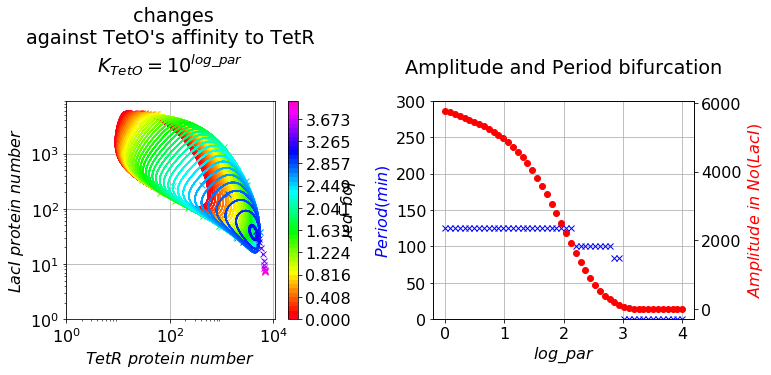

In [11]:
### figure6
# %matplotlib notebook

tl=''' changes
against TetO's affinity to TetR
$K_{TetO} = 10^{log\_par}$
'''
tlR='''Amplitude and Period bifurcation
'''

# exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=1000.*60.#### set the duration of the simulation
nt=10; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(30000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)

#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(0,4,50);
siz=len(lst)

cmd_onthefly_param='''
#### Temporary parameter/variable change
K_TetO = 10**log_par;
    
'''

for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=20) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
#     ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    axL.plot(p_TetR_obs,p_LacI_obs,color=col,label=lbl)
    axL.plot(p_TetR_obs[-1],p_LacI_obs[-1],'x',color=col)
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('$TetR\ protein\ number$')
axL.set_ylabel('$LacI\ protein\  number$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axL.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
cbar.set_label('$log\_par$', rotation=270)
# plt.colorbar( [0,1],ax=axL)
# norm = mpl.colors.Normalize(vmin=-2, vmax=3)
# cb = mpl.colorbar.ColorbarBase(axL, cmap=cm, norm=norm, spacing='proportional')
# plt.show(fig1)

# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')
axR.set_ylim(0,300)

axL.grid(True)
axR.grid(True)

plt.tight_layout()
plt.savefig('resources/K_TetO_singlevar.jpg',dpi=300)

/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


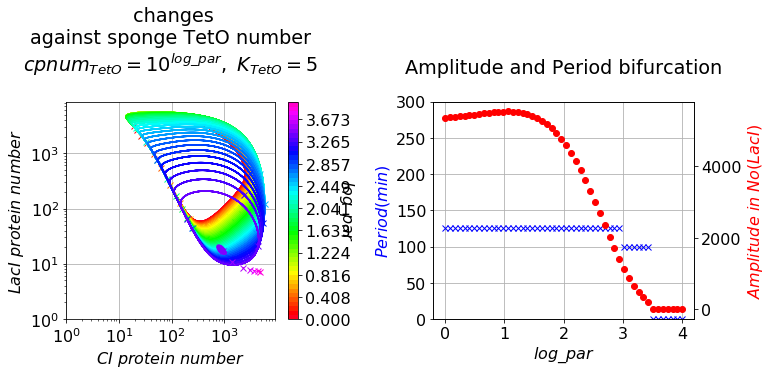

In [12]:
### figure7
# %matplotlib notebook


tl=''' changes
against sponge TetO number
$cpnum_{TetO} = 10^{log\_par},\ K_{TetO}=5$
'''
cmd_onthefly_param='''
#### Temporary parameter/variable change
K_TetO=5.;
cpnum_TetO=10**log_par;
'''

#### passing a list to vary parameter on-the-fly
# lst=np.arange(0.,1.,.25);
lst=np.linspace(0,4,50);
siz=len(lst)
######


# exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=1000.*60.#### set the duration of the simulation
nt=10; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(30000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)

for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=20) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
#     ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    axL.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axL.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('$CI\ protein\ number$')
axL.set_ylabel('$LacI\ protein\  number$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axL.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
cbar.set_label('$log\_par$', rotation=270)
# plt.colorbar( [0,1],ax=axL)
# norm = mpl.colors.Normalize(vmin=-2, vmax=3)
# cb = mpl.colorbar.ColorbarBase(axL, cmap=cm, norm=norm, spacing='proportional')
# plt.show(fig1)

# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')
axR.set_ylim(0,300)

axL.grid(True)
axR.grid(True)

plt.tight_layout()
plt.savefig(figname,dpi=300)

log_par = 0.0, period estimate: 7500.000000, amplitude:5912.775961, mean_LacI:2241.342199
log_par = 0.0, period estimate: 7500.000000, amplitude:5590.997422, mean_LacI:2007.931201
log_par = 0.0, period estimate: 7500.000000, amplitude:5131.476709, mean_LacI:1687.122823
log_par = 0.0, period estimate: 7500.000000, amplitude:4370.350464, mean_LacI:1288.226382
log_par = 0.0, period estimate: 7500.000000, amplitude:3130.397396, mean_LacI:882.987555
log_par = 0.0, period estimate: 6666.666667, amplitude:1581.712858, mean_LacI:427.521958
log_par = 0.0, period estimate: 5454.545455, amplitude:440.458118, mean_LacI:150.388789


/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


log_par = 0.0, period estimate: 0.000000, amplitude:0.987310, mean_LacI:36.660945
log_par = 0.0, period estimate: 0.000000, amplitude:0.000000, mean_LacI:10.276358
log_par = 0.0, period estimate: 0.000000, amplitude:0.000000, mean_LacI:7.221625


/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in greater


log_par = 0.444444444444, period estimate: 0.000000, amplitude:nan, mean_LacI:nan
log_par = 0.444444444444, period estimate: 7500.000000, amplitude:5698.580536, mean_LacI:2041.903795
log_par = 0.444444444444, period estimate: 7500.000000, amplitude:5191.141540, mean_LacI:1607.959080
log_par = 0.444444444444, period estimate: 7500.000000, amplitude:4387.438724, mean_LacI:1287.309481
log_par = 0.444444444444, period estimate: 7500.000000, amplitude:3131.199958, mean_LacI:845.276241
log_par = 0.444444444444, period estimate: 6666.666667, amplitude:1580.418412, mean_LacI:426.892879
log_par = 0.444444444444, period estimate: 6000.000000, amplitude:440.031004, mean_LacI:141.150000
log_par = 0.444444444444, period estimate: 0.000000, amplitude:0.951167, mean_LacI:36.633959
log_par = 0.444444444444, period estimate: 0.000000, amplitude:0.000000, mean_LacI:10.271740
log_par = 0.444444444444, period estimate: 0.000000, amplitude:0.000000, mean_LacI:7.221558
log_par = 0.888888888889, period estim

/home/tempu/.local/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


log_par = 2.22222222222, period estimate: 0.000000, amplitude:0.000000, mean_LacI:7.219434
log_par = 2.22222222222, period estimate: 7500.000000, amplitude:4142.661413, mean_LacI:931.063688
log_par = 2.22222222222, period estimate: 7500.000000, amplitude:4004.937864, mean_LacI:901.725555
log_par = 2.22222222222, period estimate: 7500.000000, amplitude:3591.511041, mean_LacI:842.188013
log_par = 2.22222222222, period estimate: 7500.000000, amplitude:2673.113794, mean_LacI:615.716348
log_par = 2.22222222222, period estimate: 6666.666667, amplitude:1388.030934, mean_LacI:354.747887
log_par = 2.22222222222, period estimate: 6000.000000, amplitude:395.391896, mean_LacI:127.197944
log_par = 2.22222222222, period estimate: 0.000000, amplitude:0.015363, mean_LacI:34.187041
log_par = 2.22222222222, period estimate: 0.000000, amplitude:0.000000, mean_LacI:9.873449
log_par = 2.22222222222, period estimate: 0.000000, amplitude:0.000000, mean_LacI:7.215604
log_par = 2.66666666667, period estimate: 

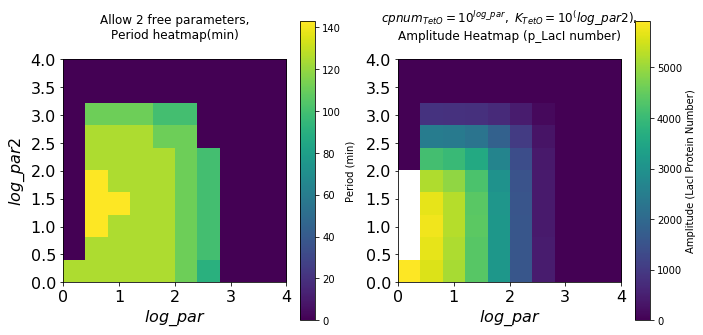

In [13]:
###figure 8
# %matplotlib notebook

tl=''' changes
against sponge TetO number
$cpnum_{TetO} = 10^{log\_par},\ K_{TetO}=5$
'''
cmd_onthefly_param='''
#### Temporary parameter/variable change
K_TetO=10**log_par2;
cpnum_TetO=10**log_par;
'''

#### passing a list to vary parameter on-the-fly
# lst=np.arange(0.,1.,.25);
lst=np.linspace(0,4,10);
lst2=np.linspace(0,4,10);
siz=len(lst)
######


figname='resources/TetO_bivariate.jpg'

tlR='''Amplitude and Period bifurcation
'''
# exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()




#### timescales
t_max=5000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(60000*nt); 
num_traj=1;

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);

    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)

perlst=[];
amplst=[];
for i,log_par in enumerate(lst):
    perlst+=[[]];
    amplst+=[[]];
    for j,log_par2 in enumerate(lst2):

        s_obss=[None]*num_traj;
        tic=timer.time()
    #     step=10**log_par;
        for k in range(num_traj):
            exec(cmd_default_param)
            exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

            exec(cmd_onthefly_param)
            exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

    #         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
            s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
            t_obs=t_obs_out[-lc_step:];
            s_obs=s_obs[-lc_step:,:];

            s_obss[k]=(s_obs.tolist());
        s_obss=np.array(s_obss);
        s_obs=s_obss.mean(axis=0)
        s_obs_std=s_obss.std(axis=0,ddof=1);
        s_obs_var=s_obss.var(axis=0,ddof=1);
        s_obs_max=s_obs+s_obs_std
    #     print(timer.time()-tic)
        exec(cmd_unpack_allobs)
        col=cm(1.*i/(siz));
        lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
        period,amplitude,avg=analyse(p_LacI_obs,debug=1,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)


        perlst[-1]+=[period];
        amplst[-1]+=[amplitude];


 


plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
cm=plt.get_cmap('gist_rainbow')
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})


mpl.rcParams.update({'font.size': 10})

cs=np.array(perlst)/60
imL=axL.imshow(cs,extent=[0,4,0,4],origin='lower')
#           norm=mpl.colors.LogNorm(vmin=cs.min()+1, vmax=cs.max()));
cs=np.array(amplst)
imR=axR.imshow(cs,extent=[0,4,0,4],origin='lower')
#               norm=mpl.colors.LogNorm(vmin=cs.min()+1, vmax=cs.max()));

cbar=plt.colorbar(imL,ax=axL)
cbar.set_label('Period (min)')
cbar=plt.colorbar(imR)
cbar.set_label('Amplitude (LacI Protein Number)')

tl='''Allow 2 free parameters,
Period heatmap(min)
'''
tlR = '''$cpnum_{TetO} = 10^{log\_par},\ K_{TetO}=10^(log\_par2)$,
Amplitude Heatmap (p_LacI number)
'''

axL.set_title(tl);
axR.set_title(tlR);
axL.set_ylabel('$log\_par2$')
axL.set_xlabel('$log\_par$')

axR.set_xlabel('$log\_par$')
# axR.set_ylabel('$log\_par2$')



plt.savefig(figname,dpi=300)
print('done')

/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


KeyboardInterrupt: 

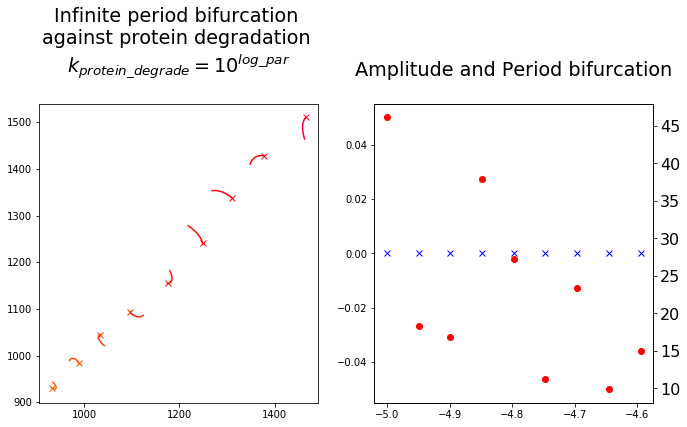

In [14]:
#figure9a
# %matplotlib notebook

tl='''Infinite period bifurcation 
against protein degradation 
$k_{protein\_degrade} = 10^{log\_par}$
'''
tlR='''Amplitude and Period bifurcation
'''

# exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
# fig1=plt.figure(figsize=[5.5,5.5])

# cbaxes = fig1.add_axes([0.0, 0.1, 0.012, 0.8])
axL=fig1.add_subplot(1,2,1)
# axL=fig1.add_axes([0.15, 0.1, 0.4, 0.8])

axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=10000.*60.#### set the duration of the simulation
nt=2; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(120000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)


#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(-5.,-1,80);
siz=len(lst)
#####


cmd_onthefly_param='''
#### Temporary parameter/variable change
k_dp=10**(log_par)
    
'''

for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
#     ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    axL.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axL.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('$CI\ protein\ number$')
axL.set_ylabel('$LacI\ protein\  number$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axL.contourf(Z, levels, cmap=cm)

# cbaxes = fig1.add_axes([0.1, 0.1, 0.03, 0.8])
cbar=plt.colorbar(CS3,ax=axL)
cbar.set_label('$log\_par$', rotation=270)
# plt.colorbar( [0,1],ax=axL)
# norm = mpl.colors.Normalize(vmin=-2, vmax=3)
# cb = mpl.colorbar.ColorbarBase(axL, cmap=cm, norm=norm, spacing='proportional')
# plt.show(fig1)

# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')


axL.grid(True)
axR.grid(True)

plt.tight_layout()
plt.savefig('resources/k_dp_varB.jpg',dpi=300)

In [ ]:
### figure 9b
# %matplotlib notebook

tl=''' changes
against mRNA degradation rate
$k_{mRNA degrade} = 10^{log\_par}$
'''
tlR='''Amplitude and Period bifurcation
'''

# exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,5.5])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()

#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(-6.,0,80);
siz=len(lst)

cmd_onthefly_param='''
#### Temporary parameter/variable change
k_dm = 10**log_par;
    
'''

#### timescales
t_max=1000.*60.#### set the duration of the simulation
nt=10; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(30000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)



for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=20) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
#     ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    axL.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axL.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('$CI\ protein\ number$')
axL.set_ylabel('$LacI\ protein\  number$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axL.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
cbar.set_label('$log\_par$', rotation=270)
# plt.colorbar( [0,1],ax=axL)
# norm = mpl.colors.Normalize(vmin=-2, vmax=3)
# cb = mpl.colorbar.ColorbarBase(axL, cmap=cm, norm=norm, spacing='proportional')
# plt.show(fig1)

# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')
axR.set_ylim(0,300)

axL.grid(True)
axR.grid(True)

plt.tight_layout()
plt.savefig('resources/k_dm_singlevar.jpg',dpi=300)

In [ ]:
# print(cmd_init_4figures)

def func_dump(x):
    with open('temp','w') as f:
        pickle.dump(x,f)
def func_load():
    with open('temp','r') as f:
        return(pickle.load(f))

def check_perdist(s_obss,period=6000, plot = 0,cap=None):
    x=int(max(period*nt/10,80));
    tic=timer.time();
    cs=np.expand_dims(np.array(s_obss),-1)[:,:,0];

    #     s_obss=np.array(s_obss)
    ts = list(x/nt/60 for x in range(cs.shape[1]))
    extent=[0 , ts[-1] ,0 ,cs.shape[0]];
    cs=s_obss[:,:,0];
    #     print(cs.shape)
    mcs=convolve2d(cs,np.array([[1./x]*x]),'same');

    #     perlst2d=np.array([]);
    #     pklst2d =np.array([]);

    con_width= len(peak_finder(ts,mcs[0]))+3;
    #     plst=np.array([]);
    plst = [];

    for traj in mcs:
        pks=peak_finder(ts,traj);
        pks+=[[0.,0.]]*(con_width-len(pks))
    #         pks=np.array(pks)/np.array([60.*nt, 1.])
    #         pkts,pkys=pks.T
    #         pkts = pkts/60/nt;
    #     dpkts=np.diff(pkts).tolist();
    #         pkts=pkts.tolist();
    #         pkys=pkys.tolist();
    #     perlst2d+=[dpkts+[float('nan')]*(con_width-len(dpkts))]
    #         perlst2d+=[pkts+[0]*(con_width-len(pkts))]

    #         plst=np.concatenate((plst,np.expand_dims(pks)),axis = 0);
        plst=plst+[pks];
    plst=np.array(plst);
    # perlst2d=plst[:,1:,0]-np.expand_dims(plst[:,0,0],-1);
    perlst2d=plst[:,0:,0]-np.expand_dims(plst[:,0,0],-1);
    perlst2d=plst[:,1:,0]-np.expand_dims(plst[:,0,0],-1);
    amplst2d=plst[:,:,1];
    print(timer.time()-tic)    
    return ((cs,perlst2d,amplst2d));

def plot_perdist(data,plot=1,*args):
    (cs,perlst2d,amplst2d)=data;
    ts = list(x/nt/60 for x in range(cs.shape[1]))
    extent=[0 , ts[-1] ,0 ,cs.shape[0]];
    
    if plot:
        fig1 = plt.figure(figsize=(10,8))
        axL=fig1.add_subplot(2,2,1)
        axR=fig1.add_subplot(2,2,2)
        ax3=fig1.add_subplot(2,2,3)
        ax4=fig1.add_subplot(2,2,4)
    axL.set_title(tl);
    cm = plt.get_cmap('gist_rainbow')

    #####
    imL=axL.imshow(cs,extent=extent)
    axL.axis('auto')
    cbar=plt.colorbar(imL,ax=axL)
    cbar.set_label('$LacI number$', rotation=270)
    axL.set_title('Oscillation in LacI number')
    axL.set_ylabel('simulation run')
    axL.set_xlabel('time(min)')

    ####
    edge=np.linspace(perlst2d.min(),perlst2d.max(),100);
    edge_amp=np.linspace(amplst2d.min(),amplst2d.max(),100);
    # axR.set_xlim(amplst2d.min(),amplst2d.max())
    perlst_var=perlst2d.var(axis=0,ddof=1)
    perlst_mean=perlst2d.mean(axis=0)
    if cap == None:
        pass
    else:
        perlst2d=perlst2d[:,:cap]
    for i,pers in enumerate(perlst2d.T):
        if (pers>0).mean()>.1:
            lbl='period %d'%i;
            pers=pers[pers>0]
            ax4.hist(pers,bins=edge,label=lbl)
            amps=amplst2d[:,i];
            axR.hist(amps[amps>1],bins=edge_amp,label=lbl);

    #             ax4.hist(perlst2d[:,ti],bins=edge)
            mx=i;

#     ax4.set_title('Phase distribution')
    ax4.set_xlabel('Phase in Time (min)')
    ax4.set_ylabel('Counts')
    ax4.legend()
#     axR.set_title('Peak height distribution')
    axR.set_xlabel('Peak height(p_LacI number)')
    axR.set_ylabel('Counts')
    axR.set_title('Peak height distribution')
    axR.legend()
   
    xs=perlst_mean[:mx];
    ys=perlst_var[:mx]
    # p = np.poly1d( np.polyfit(xs[1:], ys[1:], 1))
    p = np.poly1d( np.polyfit(xs[0:], ys[0:], 1))
    ax3.plot(xs,ys,'x');
    ax3.plot(xs,list(p(x) for x in xs),'r-');
    # ax3.set_title('Smoothed LacI number')
    ax3.set_ylabel('$Variance in phase(min^2)$')
    ax3.set_xlabel('Time(min)\n'+r'$\frac{Variance}{Mean}=%2.2f$'%(p(1)-p(0)))
#     ax3.text(0.2,5.5,r'$\frac{Variance}{Mean}=%2.2f$'%p(1));
    ax3.set_xlim(0,perlst2d.max())
    ax3.set_ylim(0,ys.max()*1.1);
    
    return((fig1,(axL,axR,ax3,ax4)))



#     return ((cs,perlst2d,amplst2d));

In [ ]:
tl='stoch_test'

exec(cmd_init_4figures)

#### timescales
t_max=500.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
step=5;
num_threads=6;
num_traj=30;

exec(cmd_default_setup)

cmd_onthefly_param='''
#### Temporary parameter/variable change
#         step=1E-3;
step=5;
#         cpnum=10**log_par;
#         cpnum=10;
#         k_p=0.0005;
#K=40;

'''

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot0_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot0_det);
#     def dot_det(s,t,param):
#         s[np.isnan(s)]=0;
#         exec(cmd_unpack_all);
#         exec(cmd_calcrates);
#         exec(cmd_wrap_all);
#         return(sdot)

def worker(*args):
#     traj=odeint(dot_det,s0,t_obs,args=(param,));
#     traj=gill_model_strict(model,s0,t_obs,param=param)
    t_obs,traj=gill_model(cmd_calcrates,s0);
#     print(args)
    return(traj)

#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(0,3,8)
siz=len(lst)

exec(cmd_default_param)
exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.
exec(cmd_pack_all)
tic=timer.time()
t_obs,s_obs=gill_model(dot_gill,s0);
toc=timer.time()-tic;
print('estimated time {}s for each of {} param, {} in total'.format(toc*num_traj,len(lst),toc*num_traj*len(lst)))

if num_threads >1: p=multiprocessing.Pool(num_threads);
# out=p.map(worker, range(25));
# p.close()
s_obsss=[];
for i,log_par in enumerate(lst):
    s_obss=[None]*num_traj;
    tic=timer.time()
    exec(cmd_onthefly_param)
    exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all
    
    
    if num_threads >1:
#         s_obss = p.map(worker, range(num_traj))
        s_obss = p.map_async(worker, range(num_traj)).get(9999999)
        t_obs=t_obs_out[-lc_step:];        
        
    else:
        for j in range(num_traj):
            t_obs_out,s_obs_out=gill_model(dot_gill,s0); ### run stochastic model
    #         s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
            t_obs=t_obs_out[-lc_step:];
            s_obs=s_obs_out[-lc_step:,:];
            
            s_obss[j]=(s_obs.tolist());
    s_obsss.append(s_obss) 
    print(timer.time()-tic)
    

In [ ]:
t_obs=t_obs_out[-lc_step:];

s_obsss=np.array(s_obsss)
sp=list(s_obsss.shape);
sp.pop(0)
sp[0]=-1;
s_obss = s_obsss.reshape(sp)
s_obss.shape

In [ ]:
t_obs=t_obs_out[-lc_step:];

s_obsss=np.array(s_obsss)
sp=list(s_obsss.shape);
sp.pop(0)
sp[0]=-1;
s_obss = s_obsss.reshape(sp)
s_obss.shape

In [ ]:
### figure10
plot_perdist((cs,perlst2d,amplst2d));
figname='resources/stoachastic1.png'
plt.savefig(figname)

In [ ]:
tl='stoch_test'

exec(cmd_init_4figures)

#### timescales
t_max=1000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
step=5;
num_threads=6;
num_traj=300;

exec(cmd_default_setup)

cmd_onthefly_param='''
#### Temporary parameter/variable change
#         step=1E-3;
step=10;
#         cpnum=10**log_par;
#         cpnum=10;
#         k_p=0.0005;
#K=40;
k_dm=10**log_par;
'''

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot0_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot0_det);
#     def dot_det(s,t,param):
#         s[np.isnan(s)]=0;
#         exec(cmd_unpack_all);
#         exec(cmd_calcrates);
#         exec(cmd_wrap_all);
#         return(sdot)

def worker(*args):
#     traj=odeint(dot_det,s0,t_obs,args=(param,));
#     traj=gill_model_strict(model,s0,t_obs,param=param)
    t_obs,traj=gill_model(cmd_calcrates,s0);
#     print(args)
    return(traj)

#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
# lst=np.linspace(0,3,8)
lst=[-3.]
siz=len(lst)

exec(cmd_default_param)
exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.
exec(cmd_pack_all)
tic=timer.time()
t_obs,s_obs=gill_model(dot_gill,s0);
toc=timer.time()-tic;
print('estimated time {}s for each of {} param, {} in total'.format(toc*num_traj,len(lst),toc*num_traj*len(lst)))

if num_threads >1: p=multiprocessing.Pool(num_threads);
# out=p.map(worker, range(25));
# p.close()
s_obsss=[];
for i,log_par in enumerate(lst):
    s_obss=[None]*num_traj;
    tic=timer.time()
    exec(cmd_onthefly_param)
    exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all
    
    
    if num_threads >1:
#         s_obss = p.map(worker, range(num_traj))
        s_obss = p.map_async(worker, range(num_traj)).get(9999999)
        t_obs=t_obs_out[-lc_step:];        
        
    else:
        for j in range(num_traj):
            t_obs_out,s_obs_out=gill_model(dot_gill,s0); ### run stochastic model
    #         s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
            t_obs=t_obs_out[-lc_step:];
            s_obs=s_obs_out[-lc_step:,:];
            
            s_obss[j]=(s_obs.tolist());
    s_obsss.append(s_obss) 
    print(timer.time()-tic)
    

In [ ]:
t_obs=t_obs_out[-lc_step:];

s_obsss=np.array(s_obsss)
sp=list(s_obsss.shape);
sp.pop(0)
sp[0]=-1;
s_obss = s_obsss.reshape(sp)
s_obss.shape

In [ ]:
s_obs=s_obss[:,:,:2]
plot = 1
cap=5
period=6000
nt=1;
cs,perlst2d,amplst2d=check_perdist(s_obss[:,:,:2],period=period)
print('done')

In [ ]:
plot_perdist((cs,perlst2d,amplst2d));
figname='resources/stoachastic_kdm3.jpg'
plt.savefig(figname)